# Dynesty fit

18 November 2019

This notebook is about doing the same fits as before, but this time, using `dynesty`. The idea is that we're explicitly trying to find the _best fit_, to see how good of a fit is possible, as opposed to trying to constrain parameters per se.

In [49]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import dynesty

from multiprocessing import Pool

from helpers import DefaultImage

# Generate original image

These images do not have noise (like shot noise).

In [74]:
N = 1
zs = 1.0
zl = .2
zd = .2 # interloper redshift
image_obj = DefaultImage(N, zl=zl, zd=zd, zs=zs)
image = image_obj.image

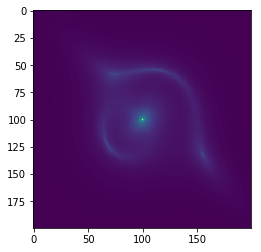

In [75]:
plt.imshow(image)

# Define fit model

In [76]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

In [77]:
# assume 1 interloper/subhalo for now
lens_model_fit_list = ['SPEP']+['NFW']*N if zl < zd else ['NFW']*N+['SPEP']
lens_model_fit = LensModel(lens_model_list=lens_model_fit_list,
                         z_source=zs, multi_plane=False)

image_model_fit = ImageModel(data_class=image_obj.pixel_grid,
                             psf_class=image_obj.psf,
                             lens_model_class=lens_model_fit,
                             source_model_class=image_obj.light_model_source,
                             lens_light_model_class=image_obj.light_model_lens,
                             kwargs_numerics=image_obj.kwargs_numerics)

def gen_image_fit(kwargs_lens_model):
    image = image_model_fit.image(kwargs_lens=kwargs_lens_model,
                                  kwargs_source=image_obj.kwargs_light_source,
                                  kwargs_lens_light=image_obj.kwargs_light_lens)
    # (could also add kwargs_ps)
    return image

def error(image1, image2):
    assert(image1.shape == image2.shape)
    
    diffsq = (image1 - image2).flatten()**2
    
#     skipidx = 20100 # todo maybe undo this
#     return np.sum(diffsq[:skipidx]) + np.sum(diffsq[skipidx+1:])
    return np.sum(diffsq)

def args_to_img(args):
    assert(len(args) == 2*N+2)
    rsang = args[0]
    alphars = args[1]
    xs = args[2:N+2]
    ys = args[N+2:]
#     rsang = image_obj.rsang
#     alphars = image_obj.alphars
#     xs = [args[0]]
#     ys = [args[1]]
    
    
    my_spep = image_obj.kwargs_spep
    my_nfw_list = []
    for i in range(N):
        my_nfw = {'Rs': rsang, 'alpha_Rs': alphars,
                  'center_x': xs[i], 'center_y': ys[i]}
        my_nfw_list.append(my_nfw)

    image_macro = gen_image_fit([my_spep]+my_nfw_list if zl < zd else my_nfw_list+[my_spep])
    return image_macro

def in_limits(args):
    xs = args[2:N+2]
    ys = args[N+2:]
    pos_lim = 300 #np.inf
    
    if args[0] < 0 or args[1] < 0: return False
    elif np.any(abs(xs) > pos_lim) or np.any(abs(ys) > pos_lim): return False
    elif args[0] > 2: return False # TODO: figure out what reasonable limits are
    elif args[1] > .01: return False # TODO: ditto
    else: return True

def log_prob(args):
    err = error(image, args_to_img(args))
    return -3000 * err
#     if not in_limits(args):
#         return -np.inf
#     else:
#         err = error(image, args_to_img(args))
#     return -err #note: can make walkers go closer to the optimum by multiplying the err function

In [78]:
keys = ['rsang', 'alphars'] + ['center_x']*N + ['center_y']*N
#keys = ['center_x']*N + ['center_y']*N

ndim = len(keys)

In [79]:
## Define prior ##
def prior(uni_vector):
    # Takes in an ndim vector of uniformly distributed points
    # and spreads them across the prior
    
    pos_lim = 30
    
    lows = np.array( [0,0]+[-pos_lim]*(2*N) )
    highs = np.array( [2, .01]+[pos_lim]*(2*N) )

#     lows = np.array( [-pos_lim]*(2*N) )
#     highs = np.array( [pos_lim]*(2*N) )
    return uni_vector * (highs - lows) + lows

In [ ]:
%%time

with Pool() as pool:

    # "Dynamic" nested sampling.
    sampler = dynesty.NestedSampler(log_prob, prior, ndim, pool=pool, queue_size=8)
    sampler.run_nested()#maxiter=1000)
    results = sampler.results

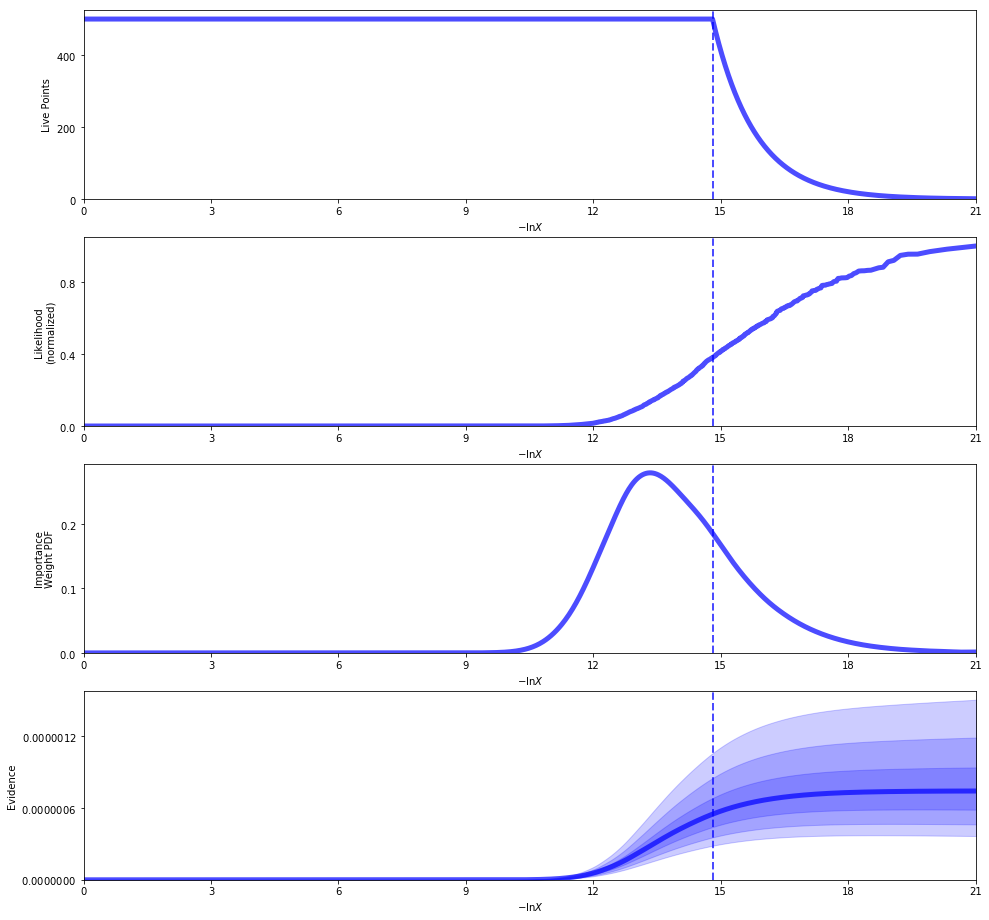

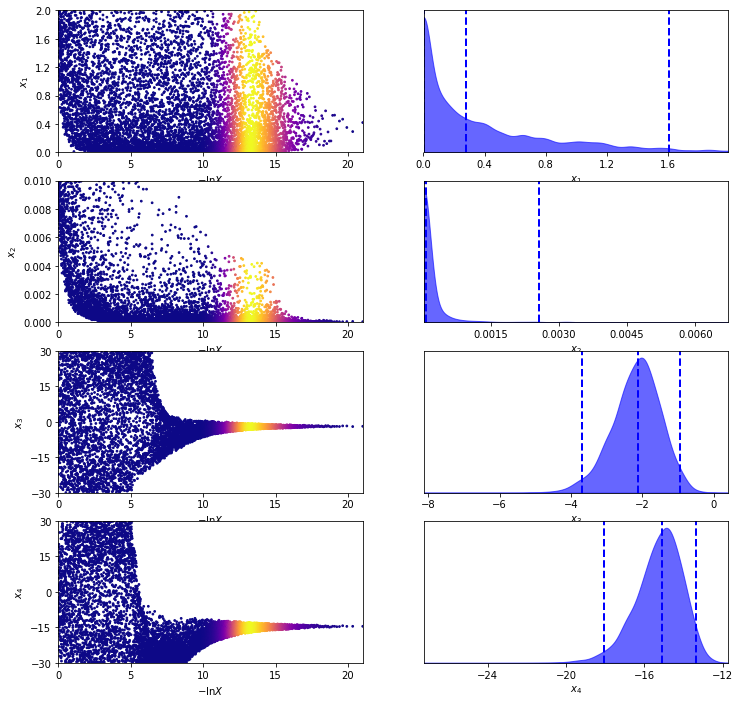

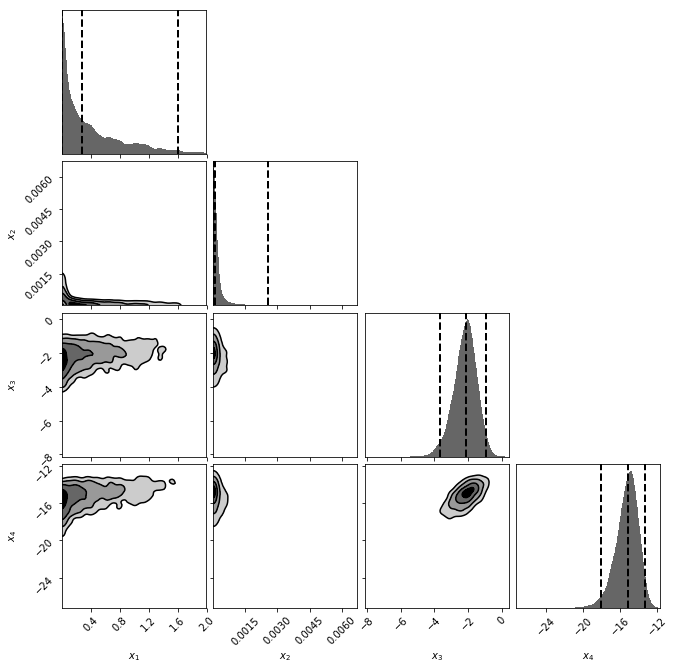

In [81]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results)

## `emcee` for comparison

In [32]:
import emcee

In [33]:
## Define initial guess: means and cov ##

means = [image_obj.rsang, image_obj.alphars]+[0]*(2*N)
#means = [0]*(2*N)

cov = 1.5 * np.ones((ndim,ndim))

for i in range(ndim):
    for j in range(ndim):
        keys_ij = [keys[i], keys[j]]
        
        ratio = 1
        for key in keys_ij:
            if key == 'rsang':
                ratio *= .03
            elif key == 'alphars':
                ratio *= .00003
            else:
                ratio *= 1
        cov[i,j] *= ratio

cov

array([[1.35e-03, 1.35e-06, 4.50e-02, 4.50e-02],
       [1.35e-06, 1.35e-09, 4.50e-05, 4.50e-05],
       [4.50e-02, 4.50e-05, 1.50e+00, 1.50e+00],
       [4.50e-02, 4.50e-05, 1.50e+00, 1.50e+00]])

In [34]:
nwalkers = 8
p0 = means + np.sqrt(np.diag(cov)) * (np.random.rand(nwalkers, ndim)-.5)

In [35]:
def logprob_bounded(args):
    if np.all(abs(args)<30):
        return log_prob(args)
    else:
        return -np.inf

In [36]:
%%time
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_bounded, pool=pool)
    mcmc_state = sampler.run_mcmc(p0, 1000, progress=True)

100%|██████████| 1000/1000 [01:07<00:00, 14.83it/s]


CPU times: user 3.3 s, sys: 420 ms, total: 3.72 s
Wall time: 1min 7s


In [ ]:
for i, key in enumerate(keys):
    print('key', key)
    for j in range(nwalkers):
        plt.plot(sampler.chain[j,:,i], alpha = .2)
    #plt.ylim(-50,50)
    plt.show()

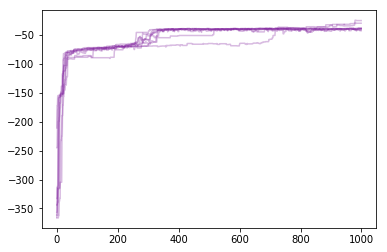

In [38]:
for j in range(nwalkers):
    plt.plot(sampler.lnprobability[j,:], alpha=.3, color='xkcd:purple')

Compared to TRUE
before, error= 0.11471617932476559
after, error= 0.014254209670421175


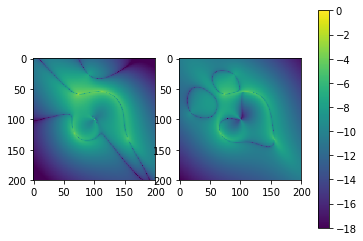

before, error= 0.07028167285969661
after, error= 0.012876639565616157


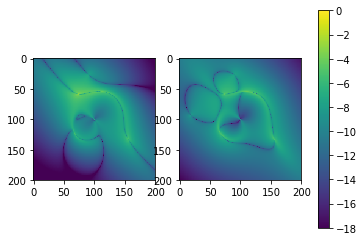

In [68]:
vmin = -18
vmax = 0
## "Residuals" compared to true image

print('Compared to TRUE')

for j in range(nwalkers)[:2]:
    f, (ax1, ax2) = plt.subplots(ncols=2)
    
    print('before, error=',error(args_to_img(sampler.chain[j,0,:]),image))
    ax1.imshow(np.log(abs(args_to_img(sampler.chain[j,0,:])-image)),
               vmin=vmin, vmax=vmax)
    print('after, error=',error(args_to_img(sampler.chain[j,-1,:]),image))

    im = ax2.imshow(np.log(abs(args_to_img(sampler.chain[j,-1,:])-image)),
                    vmin=vmin, vmax=vmax)
    
    plt.colorbar(im, ax=(ax1, ax2))
    plt.show()

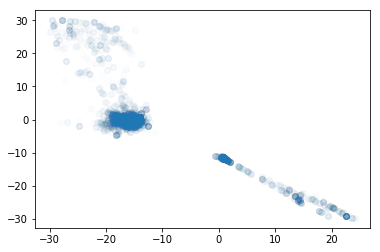

In [71]:
plt.scatter(sampler.chain[:,200:,2].flatten(),sampler.chain[:,200:,3].flatten(), alpha=.01)

In [73]:
image_obj.kwargs_lens

[{'kappa_ext': 0.0},
 {'Rs': 0.303784985137773,
  'alpha_Rs': 6.952286183143494e-05,
  'center_x': array(-1.94400063),
  'center_y': array(-14.6129154)},
 {'center_x': 0.0,
  'center_y': 0.0,
  'e1': -0.025244677188120783,
  'e2': -0.10820529231979943,
  'gamma': 2.0,
  'theta_E': 10.0}]

NOSUB vs. TRUE
null args [0.303784985137773, 0, array(-1.94400063), array(-14.6129154)]
null error 0.05228306529026036


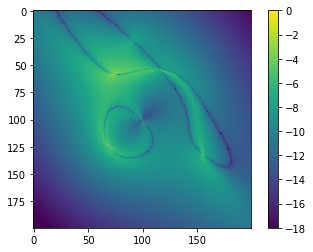

In [70]:
# no subhalos
print('NOSUB vs. TRUE')
nfw_idx = 2 if zl < zd else 1
nosub_args = ([image_obj.rsang, 0]+[image_obj.kwargs_lens[nfw_idx+i]['center_x'] for i in range(N)]
              +[image_obj.kwargs_lens[nfw_idx+i]['center_y'] for i in range(N)])
print('null args', nosub_args)
nosub_img = args_to_img(nosub_args)
print('null error', error(nosub_img, image))
plt.imshow(np.log(abs(nosub_img - image)), vmin=vmin, vmax=vmax); plt.colorbar(); plt.show()